# Fashion MNIST Basic GAN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import matplotlib
%matplotlib inline

/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework

In [30]:
from tensorflow.examples.tutorials.mnist import input_data
from keras.datasets import fashion_mnist

Using TensorFlow backend.


In [34]:
data = input_data.read_data_sets('./data/fashion', one_hot=True, reshape=False)
# data = fashion_mnist.load_data()


Extracting ./data/fashion/train-images-idx3-ubyte.gz
Extracting ./data/fashion/train-labels-idx1-ubyte.gz
Extracting ./data/fashion/t10k-images-idx3-ubyte.gz
Extracting ./data/fashion/t10k-labels-idx1-ubyte.gz


#### Print the shapes

In [35]:
X_train = data.train.images
y_train = data.train.labels

X_test = data.test.images
y_test = data.test.labels

In [5]:
print(X_train.shape)
print(y_train.shape)

(55000, 28, 28, 1)
(55000, 10)


In [6]:
index2label = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot",
}

#### Helper Functions for displaying images

In [7]:
def display_digit(x, y, i):
    s = [i for i,x in enumerate(y_train[i]) if x == 1]
    label = index2label.get(s[0])
    image = x[i].reshape([28,28])
    plt.suptitle('Example: %d Label: %s' % (i, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

In [8]:
def display_mult_flat(start, stop, x):
    images = x[start].reshape([1,784])
    for i in range(start + 1, stop):
        images = np.concatenate((images, x[i].reshape([1,784])))
        
    plt.imshow(images, cmap=plt.get_cmap('gray'))
    plt.show()

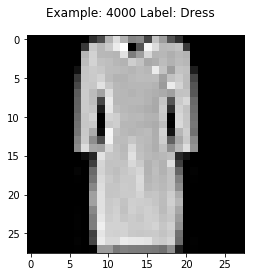

In [9]:
display_digit(X_train, y_train, 4000)

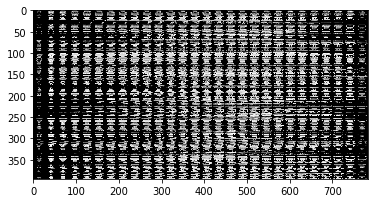

In [10]:
display_mult_flat(5,400,X_train)

In [11]:
def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

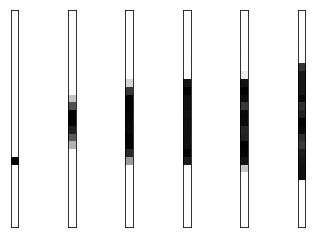

In [12]:
plot_images_separately(X_train[0])

In [13]:
def plot_images_together(images):
    fig = plt.figure()
    images = [image[:, :] for image in images]
    image = np.concatenate(images, axis=1)
    ax = fig.add_subplot(1, 3, 1)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
    plt.show()

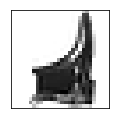

In [14]:
plot_images_together(X_train[5])

### Building the model

In [15]:
def input_placeholders(real, fake):
    X_real = tf.placeholder(tf.float32, shape=[None, real], name="X_real")
    X_fake = tf.placeholder(tf.float32, shape=[None, fake], name="X_fake")
    
    return X_real, X_fake

#### Generator

In [16]:
def generator(fake, channels, hidden_units, reuse):
    with tf.variable_scope('generator', reuse = reuse):
        model = tf.layers.dense(fake, hidden_units, activation = None)
        model = tf.maximum(0.01 * model, model)
        model = tf.layers.dense(model, channels, activation = None)
        model = tf.tanh(model) # Hyperbolic function
        
    return model

#### Discriminator

In [17]:
def discriminator(real, hidden_units, reuse):
    with tf.variable_scope('discriminator', reuse = reuse):
        model = tf.layers.dense(real, hidden_units, activation = None)
        model = tf.maximum(0.01 * model, model)
        model = tf.layers.dense(model, 1, activation = None)
        output = tf.sigmoid(model) # Sigmoid function
        
    return output, model

In [18]:
## Dimension for generator and discriminator
fake_dim = 128
real_dim = 784

## Units in hidden Layers
hidden_units_fake = 128
hidden_units_real = 128

# Output Dimension
channels = 128

In [19]:
tf.reset_default_graph()

## Placeholders for dimensions
X_real, X_fake = input_placeholders(real_dim, fake_dim)

## Generator
model_generator = generator(X_fake, channels = real_dim, hidden_units = hidden_units_fake, reuse = False)

## Discriminator_REAL
model_discriminator_real, logits_discriminator_real = discriminator(X_real,
                                                                    hidden_units = hidden_units_real,
                                                                   reuse=False)

## Discriminator_FAKE
model_discriminator_fake, logits_discriminator_fake = discriminator(model_generator,
                                                                    hidden_units = hidden_units_real,
                                                                   reuse=True)


Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.


In [20]:
X_fake

<tf.Tensor 'X_fake:0' shape=(?, 128) dtype=float32>

#### Calculating Losses for Generator Discriminator

In [21]:
loss_discriminator_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.ones_like(logits_discriminator_real) * (1 - 0.1),
    logits = logits_discriminator_real))

loss_discriminator_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
    labels=tf.zeros_like(logits_discriminator_real),
    logits = logits_discriminator_fake))

## Discriminator Loss
loss_discriminator = loss_discriminator_real + loss_discriminator_fake


## Generator Loss
loss_generator = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = tf.ones_like(
                    logits_discriminator_fake),
                    logits = logits_discriminator_fake))


In [22]:
learning_rate = 0.003

variables = tf.trainable_variables()
generator_variables = [var for var in variables if var.name.startswith('generator')]
discriminator_variables = [var for var in variables if var.name.startswith('discriminator')]

discriminator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_discriminator, 
                                                                         var_list = discriminator_variables)

generator_optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss_discriminator, 
                                                                         var_list = generator_variables)

In [23]:
batch_size = 128
epochs = 100
samples = []
losses = []

#### Training the network

In [24]:
%%time

saver = tf.train.Saver(var_list=generator_variables)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for e in range(epochs):
        for ii in range(data.train.num_examples//batch_size):
            batch = data.train.next_batch(batch_size)
        
            # passing images to discriminator
            batch_images = batch[0].reshape((batch_size, 784))
            batch_images = batch_images*2 - 1
        
            # inputs for generator
            batch_fake = np.random.uniform(-1, 1, size=(batch_size, fake_dim))
        
            _ = sess.run(discriminator_optimizer, feed_dict={X_real: batch_images, X_fake: batch_fake})
            _ = sess.run(generator_optimizer, feed_dict={X_fake: batch_fake})
            
        train_loss_d = sess.run(loss_discriminator, {X_fake: batch_fake, X_real: batch_images})
        train_loss_g = loss_generator.eval({X_fake: batch_fake})
    
        print("Epoch {}/{}...".format(e+1, epochs),
              "Discriminator Loss: {:.4f}...".format(train_loss_d),
              "Generator Loss: {:.4f}".format(train_loss_g))
    
        losses.append((train_loss_d, train_loss_g))
    
        # Sample from generator
        sample_fake = np.random.uniform(-1, 1, size(16, fake_dim))
        gen_samples = sess.run(
                        generator(X_fake, channels=real_dim, hidden_units = hidden_units_fake, reuse=True),
                        feed_dict={X_fake: sample_fake})
        samples.append(gen_samples)
        saver.save(sess, './checkpoints/generator.ckpt')

InvalidArgumentError: You must feed a value for placeholder tensor 'X_real' with dtype float and shape [?,784]
	 [[node X_real (defined at <ipython-input-15-927cec37ea52>:2) ]]

Caused by op 'X_real', defined at:
  File "/home/rodrigo/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/rodrigo/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_loop.start()
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-254f1525543f>", line 4, in <module>
    X_real, X_fake = input_placeholders(real_dim, fake_dim)
  File "<ipython-input-15-927cec37ea52>", line 2, in input_placeholders
    X_real = tf.placeholder(tf.float32, shape=[None, real], name="X_real")
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 2077, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_array_ops.py", line 5791, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/rodrigo/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'X_real' with dtype float and shape [?,784]
	 [[node X_real (defined at <ipython-input-15-927cec37ea52>:2) ]]


In [25]:
_ = np.random.uniform(-1, 1, size=(1, 2))
print(_)

[[-0.85648387 -0.3689902 ]]


In [26]:
10//5

2

In [27]:
import tensorflow as tf

x = tf.placeholder("float", None)
y = x * 2

with tf.Session() as session:
    result = session.run(y, feed_dict={x: [1, 2, 3]})
    print(result)

[2. 4. 6.]


In [28]:
len(batch_images[0])

784

In [29]:
x

<tf.Tensor 'Placeholder:0' shape=<unknown> dtype=float32>